In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import onnx
import onnx_tf
import onnxruntime

rng = np.random.default_rng()

# Load ACAS XU Network. Distill data-free. Verify some properties.

In this notebook, we demonstrate network distillation and verification using acas xu.

In [2]:
acas_xu = onnx.load("/Users/jperrsau/cu-src/thesis/src/nnenum/examples/acasxu/data/ACASXU_run2a_1_1_batch_2000.onnx")

acas_xu = onnx_tf.backend.prepare(acas_xu)

inputs = (rng.random((2000,1,1,5),dtype="float32")-0.5)*2
# synthetic_inputs = scipy.qmc.sobol()

onnx_outputs = acas_xu.run(inputs)

outputs = onnx_outputs.linear_7_Add

2022-07-19 11:32:36.174357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


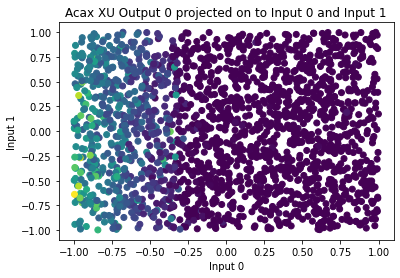

In [4]:
plt.scatter(inputs[:,0,0,0], inputs[:,0,0,1], c=outputs[:,0])
plt.title("Acax XU Output 0 projected on to Input 0 and Input 1")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

## Train student network using Data-Free Distillation

In [23]:
## Generate synthetic dataset using a random distribution.

synthetic_inputs = (rng.random((2000,1,1,5),dtype="float32")-0.5)*2
# synthetic_inputs = scipy.qmc.sobol()

onnx_outputs = acas_xu.run(synthetic_inputs)

synthetic_inputs = synthetic_inputs.reshape((2000,5))
synthetic_outputs = onnx_outputs.linear_7_Add



In [24]:
## Acas XU original is 8 hidden layers with 300 relu each
#Katz, G., Barrett, C., Dill, D.L., Julian, K., Kochenderfer, M.J. (2017). Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks. In: Majumdar, R., Kunčak, V. (eds) Computer Aided Verification. CAV 2017. Lecture Notes in Computer Science(), vol 10426. Springer, Cham. https://doi.org/10.1007/978-3-319-63387-9_5

hidden_layer_width=200
num_hidden_layers=4

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(5))

student_model = tf.keras.Sequential(layers)

student_model.summary()

## Julian K uses an asymmetric loss function based on MSE. We use MSE here for now.

student_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.KLDivergence(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    optimizer=tf.keras.optimizers.Adam(0.001)
)

student_model.fit(
    x=synthetic_inputs,
    y=synthetic_outputs,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    epochs=500,
    batch_size=128,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    ]
    )


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 200)               1200      
                                                                 
 dense_38 (Dense)            (None, 200)               40200     
                                                                 
 dense_39 (Dense)            (None, 200)               40200     
                                                                 
 dense_40 (Dense)            (None, 200)               40200     
                                                                 
 dense_41 (Dense)            (None, 5)                 1005      
                                                                 
Total params: 122,805
Trainable params: 122,805
Non-trainable params: 0
_________________________________________________________________


63/63 [==============================] - 0s 1ms/step


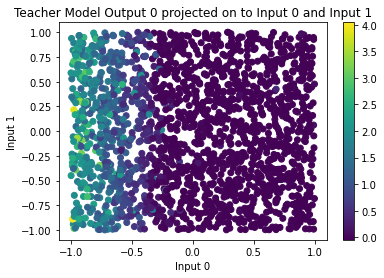

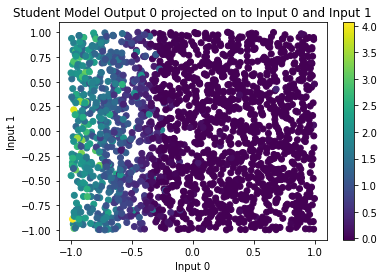

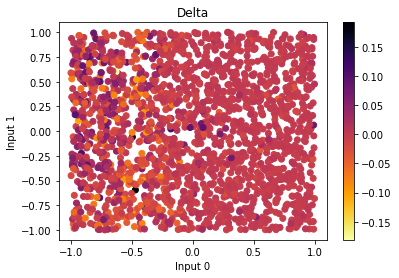

In [32]:
synthetic_outputs_pred = student_model.predict(synthetic_inputs)

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs_pred[:,0])
plt.title("Teacher Model Output 0 projected on to Input 0 and Input 1")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs[:,0])
plt.title("Student Model Output 0 projected on to Input 0 and Input 1")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

plt.scatter(synthetic_inputs[:,0], synthetic_inputs[:,1], c=synthetic_outputs[:,0]-synthetic_outputs_pred[:,0],cmap="inferno_r")
plt.title("Delta")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.colorbar()
plt.show()

In [37]:
(synthetic_outputs - synthetic_outputs_pred)[:,0].max()

0.19182211

In [40]:
np.linalg.norm(synthetic_outputs, axis=1).mean()

1.6847858

In [35]:
np.linalg.norm((synthetic_outputs - synthetic_outputs_pred), axis=1).max()

0.46071246

# TODO: Verify both networks


## Data Driven Method
Ensure that every data point in the dataset satisfying the preconditions evaluate to the correct output.


In [44]:
padding = 0.5

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value
properties = (
    ("Q1", inputs[:,(inputs[0] > padding) & (inputs[1] > padding)], 0),
    ("Q2", inputs[:,(inputs[0] > padding) & (inputs[1] < -padding)], 1),
    ("Q3", inputs[:,(inputs[0] < -padding) & (inputs[1] < -padding)], 2),
    ("Q4", inputs[:,(inputs[0] < -padding) & (inputs[1] > padding)], 3),
)

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = np.argmax(the_model.predict(property_data.T), axis=1)
        assert (np.abs(prediction - property_output)<0.1).all() , f"{property_name} failed"
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
3/3 [==============================] - 0s 2ms/step
Model student, Q1 property passed!
2/2 [==============================] - 0s 3ms/step
Model student, Q2 property passed!
3/3 [==============================] - 0s 1ms/step
Model student, Q3 property passed!
2/2 [==============================] - 0s 2ms/step
Model student, Q4 property passed!
Inspecting teacher
3/3 [==============================] - 0s 2ms/step
Model teacher, Q1 property passed!
2/2 [==============================] - 0s 2ms/step
Model teacher, Q2 property passed!
3/3 [==============================] - 0s 2ms/step
Model teacher, Q3 property passed!
2/2 [==============================] - 0s 2ms/step
Model teacher, Q4 property passed!


## Probabilistic Method
Ensure that a random samples from within the precondition produce the correct output.

In [45]:
padding = 0.1
max_distance = 2.0
samples = 4000

# This property list is of the format:
# (Name of property, region of input for which it must apply, output value

probabilistic_inputs = np.random.uniform(padding, max_distance, (2,samples))

for model_name, the_model in [("student", student_model), ("teacher", model)]:
    print(f"Inspecting {model_name}")
    for property_name, property_data, property_output in properties:
        prediction = the_model.predict(property_data.T)
        errors = (np.abs(prediction - property_output) < 0.1)
        if not errors.all():
            print(f"{property_name} failed")
            print(property_data[:,errors.flatten()==False])
            continue
        print(f"Model {model_name}, {property_name} property passed!")

Inspecting student
3/3 [==============================] - 0s 1ms/step
Q1 failed


IndexError: boolean index did not match indexed array along dimension 1; dimension is 66 but corresponding boolean dimension is 264

## Analytic Method
Ensure that all points within the precondition produce the correct output.

### Using abstraction
### Complete


## NNenum

In [59]:
tf.saved_model.save(student_model, "./distill_test_quadrants_student_model")
tf.saved_model.save(model, "./distill_test_quadrants_model")

INFO:tensorflow:Assets written to: ./distill_test_quadrants_student_model/assets
INFO:tensorflow:Assets written to: ./distill_test_quadrants_model/assets


In [60]:
!python -m tf2onnx.convert --saved-model ./distill_test_quadrants_model/ --output distill_test_model.onnx --opset 11
!python -m tf2onnx.convert --saved-model ./distill_test_quadrants_student_model/ --output distill_test_student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-07-08 11:36:46,074 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-07-08 11:36:46,335 - INFO - Signatures found in model: [serving_default].
2022-07-08 11:36:46,335 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-07-08 11:36:46,335 - INFO - Output names: ['dense_59']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-07-08 11:36:46,387 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.com

In [79]:
property = """
; Quadrant 1 Property

(declare-const X_0 Real)
(declare-const X_1 Real)

(declare-const Y_0 Real)
(declare-const Y_1 Real)
(declare-const Y_2 Real)
(declare-const Y_3 Real)


(assert (>= X_0 0.2))
(assert (<= X_0 1.0))
(assert (>= X_1 0.2))
(assert (<= X_1 1.0))

(assert (<= Y_0 0.0))
"""

with open("distill_quadrant_test.vnnlib", "w") as file:
    file.write(property)


In [80]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_test_model.onnx /my_work/distill_test.vnnlib